#### create training dataset from aeon raw data

In [ ]:
# exp 0.2
# solo BAA-1101818 (tail+ear painted)
# 2022-06-23 08:39:04.261089801	BAA-1101818	26.4	Enter 
# 2022-06-23 11:14:46.121759892	BAA-1101818	28.0	Exit
# 2022-06-24 09:32:37.183360100	BAA-1101818	26.9	Enter (ear repainted)
# 2022-06-24 12:29:54.365859985	BAA-1101818	27.8	Exit

# solo BAA-1101819
# 2022-06-21 13:28:10.593659878	BAA-1101819	25.4	Enter
# 2022-06-21 16:34:29.241280079	BAA-1101819	26.4	Exit

# multianimal BAA-1101818 and BAA-1101819
# 2022-06-22 10:40:00	        BAA-1101819	24.9	Enter
# 2022-06-22 13:29:04.050240040	BAA-1101818	28.4	Exit 
# 2022-06-23 11:24:23.876420021	BAA-1101819	25.6	Enter
# 2022-06-23 14:19:39.241819859	BAA-1101818	26.4	Exit

# exp 0.3
# multianimal BAA-1102505 and BAA-1102506
# 1904-01-03 22:03:16.696000000	BAA-1102505	20	Enter
# 1904-01-03 22:03:30.928000000	BAA-1102506	20	Enter
# 1904-01-03 23:57:31.952000000	BAA-1102505	20	Exit
# 1904-01-03 23:57:37.824000000	BAA-1102506	20	Exit



In [1]:
import pandas as pd
import aeon.io.api as aeon
import matplotlib.pyplot as plt

from aeon.schema.dataset import exp02
from aeon.analysis.utils import *
from dotmap import DotMap
from pathlib import Path
from scipy import stats


def get_raw_tracking_data(
    root: str, subj_id: str, start: "pd.Timestamp", end: "pd.Timestamp"
):
    """
    Retrieves pos tracking and video data and assigns subject ID.

    :param root: The root path, or prioritised sequence of paths, where epoch data is stored.
    :param subj_id: The subject ID string to be assigned.
    :param start: The left bound of the time range to extract.
    :param end: The right bound of the time range to extract.
    :returns: A pandas data frame containing pos tracking and video data, and subject ID.
    """

    subj_video = aeon.load(root, exp02.CameraTop.Video, start=start, end=end)
    subj_pos = aeon.load(root, exp02.CameraTop.Position, start=start, end=end)
    subj_data = pd.merge_asof(
        subj_video,
        subj_pos,
        left_index=True,
        right_index=True,
        direction="nearest",
        tolerance=pd.Timedelta("1ms"),
    )[["x", "y", "id", "area", "_frame", "_path"]]
    subj_data.dropna(inplace=True)
    subj_data["id"] = subj_id
    return subj_data


def sample_n_from_bins(subj_data: "pd.DataFrame", n_samples: int = 1, n_bins: int = 50):
    """
    Uniformly samples n number of data from x number of bins.

    :param subj_data: A pandas data frame containing pos tracking and video data, and subject ID.
    :param optional n_samples: The number of samples to take from each bin.
    :param optional n_bins: The number of bins to use for sampling.
    :returns: A pandas data frame containing uniformly-sampled pos tracking and video data, and subject ID.
    """

    hist_data = stats.binned_statistic_2d(
        subj_data.x,
        subj_data.y,
        values=subj_data,
        statistic="count",
        bins=n_bins,
        range=[[0, 1440], [0, 1080]],
    )
    subj_data["bin"] = hist_data.binnumber
    sampled_data = (
        subj_data.groupby(["bin"]).sample(n=n_samples, replace=True).drop_duplicates()
    )
    return sampled_data


def create_session_dataset(session: dict, plot_dist: bool = True):
    """
    Creates a dataset for a given session dict

    :param session: A dictionary containing the root path, subject IDs, and their start and end times.
    :param optional plot_dist: Whether to plot the 1d and 2d histograms of x, y pos tracking for each subject.
    :returns: A pandas data frame containing uniformly-sampled pos tracking and video data, and subject ID.
    """
    all_subj_data = pd.DataFrame()
    for subj in session["subjects"].keys():
        subj_dict = {
            "id": subj,
            "root": session["root"],
            "start": session["subjects"][subj]["start"],
            "end": session["subjects"][subj]["end"],
        }
        subj_data = (
            create_subject_dataset(
                subj_dict, min_area=500, n_samples=2, n_bins=10
            )  # sample fewer points for manual annotation
            if "multi_" in subj
            else create_subject_dataset(subj_dict)
        )
        all_subj_data = pd.concat([all_subj_data, subj_data])
    if plot_dist:
        fig = plot_position_histograms(all_subj_data)
        fig.show()
    return all_subj_data


def plot_position_histograms(data: "pd.DataFrame", n_bins: int = 50):
    """
    Plots the 1d and 2d histograms of x, y pos tracking for each subject in a given data frame.

    :param data: A pandas data frame containing x, y pos tracking and subject ID(s).
    :returns: A plot containing 1d and 2d histograms of x, y pos tracking for each subject.
    """
    subj_ids = data["id"].unique()
    fig, ax = plt.subplots(2, len(subj_ids))
    n_bins = 50
    if len(subj_ids) == 1:
        data[["x", "y"]].plot.hist(bins=n_bins, alpha=0.5, ax=ax[0], title=subj_ids[0])
        ax[1].hist2d(
            data.x,
            data.y,
            bins=(n_bins, n_bins),
            cmap=plt.cm.jet,
        )
    else:
        for i, subj_id in enumerate(subj_ids):
            subj_data = data[data["id"] == subj_id]
            subj_data[["x", "y"]].plot.hist(
                bins=n_bins, alpha=0.5, ax=ax[0, i], title=subj_id
            )
            ax[1, i].hist2d(
                subj_data.x, subj_data.y, bins=(n_bins, n_bins), cmap=plt.cm.jet
            )

    plt.tight_layout()
    return fig


def create_subject_dataset(
    subject: dict, min_area: float = None, n_samples: int = 1, n_bins: int = 50
):
    """
    Creates a dataset for a given subject dict

    :param subject: A dictionary containing the root path, subject ID, and their start and end times.
    :param optional min_area: The minimum area of the subject to be included in the dataset.
    :param optional n_samples: The number of samples to take from each bin.
    :param optional n_bins: The number of bins to use for sampling.
    :returns: A pandas data frame containing uniformly-sampled pos tracking and video data, and subject ID.
    """
    subj_data = get_raw_tracking_data(
        subject["root"],
        subject["id"],
        subject["start"],
        subject["end"],
    )
    if min_area:
        subj_data = subj_data[subj_data.area >= min_area]
    subj_data = sample_n_from_bins(subj_data, n_samples=n_samples, n_bins=n_bins)
    return subj_data

In [2]:
# dictionaries for each session
aeon2 = {
    "root": "/ceph/aeon/aeon/data/raw/AEON2/experiment0.2/",
    "subjects": {
        "BAA-1101818": {
            "start": pd.Timestamp("2022-06-23 08:39:04.261089801"),
            "end": pd.Timestamp("2022-06-23 11:14:46.121759892"),
        },
        "BAA-1101819": {
            "start": pd.Timestamp("2022-06-21 13:28:10.593659878"),
            "end": pd.Timestamp("2022-06-21 16:34:29.241280079"),
        },
    },
    "session": "BAA-1101818_819",
    "multianimal_videos": [
        "/ceph/aeon/aeon/data/raw/AEON2/experiment0.2/2022-06-22T08-51-10/CameraTop/CameraTop_2022-06-22T11-00-00.avi"
    ],
}

aeon3 = {
    "root": "/ceph/aeon/aeon/data/raw/AEON3/presocial0.1",
    "subjects": {
        "AEON3_NTP": {
            "start": pd.Timestamp("2023-03-03 16:40:00"),
            "end": pd.Timestamp("2023-03-03 16:55:00"),
        },
        "AEON3_TP": {
            "start": pd.Timestamp("2023-03-03 17:01:00"),
            "end": pd.Timestamp("2023-03-03 17:22:00"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2023-03-03 17:23:00"),
            "end": pd.Timestamp("2023-03-03 17:43:00"),
        },
    },
    "session": "AEON3_NTP_TP_local",
    "multianimal_videos": [
        r"C:\Users\chuan\Documents\SLEAP_Test\aeon3_multi\CameraTop_2023-03-03T17-00-00_multianimal.avi"
    ],
    # multianimal "2023-03-03 17:23:00" "2023-03-03 17:43:00"
}

aeon3b = {
    "root": "/ceph/aeon/aeon/data/raw/AEON3/presocial0.1",
    "subjects": {
        "AEON3B_NTP": {
            "start": pd.Timestamp("2023-03-16 15:05:00"),
            "end": pd.Timestamp("2023-03-16 15:44:00"),
        },
        "AEON3B_TP": {
            "start": pd.Timestamp("2023-03-16 16:00:00"),
            "end": pd.Timestamp("2023-03-16 16:36:00"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2023-03-16 16:37:00"),
            "end": pd.Timestamp("2023-03-16 17:19:00"),
        },
    },
    "session": "AEON3B_NTP_TP_local",
    "multianimal_videos": [
        r"C:\Users\chuan\Documents\SLEAP_Test\aeon3_multi\CameraTop_2023-03-16T16-00-00_multianimal.avi",
        r"C:\Users\chuan\Documents\SLEAP_Test\aeon3_multi\CameraTop_2023-03-16T17-00-00_multianimal.avi",
    ],
    # multianimal "2023-03-16 16:37:00" "2023-03-16 17:19:00"
}

aeon3b_pattern = {
    "root": "/ceph/aeon/aeon/data/raw/AEON3/presocial0.1/",
    "subjects": {
        "AEON3B_NTP": {
            "start": pd.Timestamp("2023-03-29 09:40:40"),
            "end": pd.Timestamp("2023-03-29 10:07:00"),
        },
        "AEON3B_TP1": {
            "start": pd.Timestamp("2023-03-29 10:10:44"),
            "end": pd.Timestamp("2023-03-29 10:46:30"),
        },
        "AEON3B_TP2": {
            "start": pd.Timestamp("2023-03-29 10:50:10"),
            "end": pd.Timestamp("2023-03-29 11:22:00"),
        },
        "multi_animal": {
            "start": pd.Timestamp("2023-03-29 11:23:30"),
            "end": pd.Timestamp("2023-03-29 12:31:00"),
        }
    },
    "session": "AEON3B_pattern_local",
    "multianimal_videos": [
        r"C:\Users\chuan\Documents\SLEAP_Test\aeon3_multi\CameraTop_2023-03-29T11-00-00_TP1TP2.avi", # TP1 and TP2: 11:22:37 - 11:22:57
        r"C:\Users\chuan\Documents\SLEAP_Test\aeon3_multi\CameraTop_2023-03-29T11-00-00_multianimal.avi", # all mice: 11:23:30 - 12:31:00
        r"C:\Users\chuan\Documents\SLEAP_Test\aeon3_multi\CameraTop_2023-03-29T12-00-00_multianimal.avi", # all mice
    ], 
}

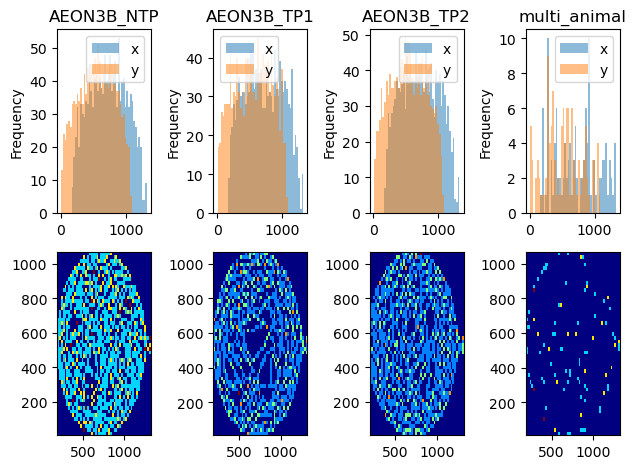

In [3]:
all_subj_data = create_session_dataset(aeon3b_pattern)
#all_subj_data.to_csv(aeon3b_pattern["session"] + ".csv")

In [1]:
import pandas as pd
import random
import sleap
import numpy as np

from pathlib import Path
from sleap.io.dataset import Labels
from sleap.io.video import Video
from sleap.gui.suggestions import VideoFrameSuggestions
from sleap.nn.config import *
from sleap.nn.inference import main as sleap_track
from sleap.nn.inference import TopDownMultiClassPredictor, Predictor, TopDownPredictor, Tracker

In [1]:
def generate_slp_dataset(session: dict, skeleton: "sleap.Skeleton"):
    """
    Generates .slp dataset for a given session dict.

    :param session: A dictionary containing the root path, subject IDs, and their start and end times.
    :param skeleton: A sleap Skeleton object.
    :returns: A sleap Labels object containing labeled frames.
    """

    subj_data = pd.read_csv(session["session"] + ".csv")
    tracks_dict = {}

    for subj_id in subj_data["id"].unique():
        if "multi_" not in subj_id:
            # create tracks dictionary from subj_ids that are not multi_animal
            tracks_dict[subj_id] = sleap.Track(spawned_on=0, name=subj_id)

    lfs = []

    # create video dictionary from new labels
    videos_dict = {}
    for video in subj_data._path.unique():
        videos_dict[video] = sleap.Video.from_filename(video)

    for _, row in subj_data.drop_duplicates(subset=["_path", "_frame"]).iterrows():
        instances = []
        if "multi_" in row.id:
            # duplicate instance for each track
            for track in tracks_dict.keys():
                instances.append(
                    sleap.Instance(
                        skeleton=skeleton,
                        track=tracks_dict[track],
                        points={"centroid": sleap.instance.Point(row.x, row.y)},
                    )
                )
        else:
            # create a new instance for each row
            instances.append(
                sleap.Instance(
                    skeleton=skeleton,
                    track=tracks_dict[row.id],
                    points={"centroid": sleap.instance.Point(row.x, row.y)},
                )
            )
        # create a new labeled frame
        lf = sleap.instance.LabeledFrame(
            video=videos_dict[row._path],
            frame_idx=row._frame,
            instances=instances,
        )
        lfs.append(lf)

    return sleap.Labels(labeled_frames=lfs)

In [15]:
# create new skeleton
skeleton = sleap.Skeleton()
skeleton.add_node("centroid")

# generate slp dataset for all subjects
labels = generate_slp_dataset(aeon3b_pattern, skeleton)

sleap.Labels.save_file(labels, aeon3b_pattern["session"] + ".slp")

#### train

In [2]:
# set initial parameters
subj_id = aeon3b_pattern["session"]
run_name_centroid = subj_id + "_topdown_top.centroid"
run_name_centered_instance = subj_id + "_topdown_top.centered_instance_multiclass"
runs_folder = "models"

try:
    skeleton
except NameError:
    # create new skeleton
    skeleton = sleap.Skeleton()
    skeleton.add_node("centroid")

In [ ]:
# split labels into train/val/test
labels = sleap.load_file(subj_id + ".slp")

# generate a 0.8/0.1/0.1 train/val/test split
labels_train, labels_val_test = labels.split(n=0.8) 
labels_val, labels_test = labels_val_test.split(n=0.5)

# Save with images
labels_train.save(subj_id + ".train.pkg.slp")#, with_images=True)
labels_val.save(subj_id + ".val.pkg.slp")#, with_images=True)
labels_test.save(subj_id + ".test.pkg.slp")#, with_images=True)

In [ ]:
# centroid model
# initalise default training job config
cfg = TrainingJobConfig()
cfg.data.labels.training_labels = subj_id + ".train.pkg.slp"
cfg.data.labels.validation_labels = subj_id + ".val.pkg.slp"
cfg.data.labels.test_labels = subj_id + ".test.pkg.slp"

# preprocessing and training params
cfg.data.preprocessing.input_scaling = 0.75 #0.5
cfg.data.instance_cropping.center_on_part = "centroid"
cfg.data.instance_cropping.crop_size = 128 # set crop size manually
cfg.optimization.augmentation_config.rotate = True
cfg.optimization.epochs = 600 #200
cfg.optimization.batch_size = 4

cfg.optimization.initial_learning_rate = 0.0001
cfg.optimization.learning_rate_schedule.reduce_on_plateau = True
cfg.optimization.learning_rate_schedule.reduction_factor = 0.5
cfg.optimization.learning_rate_schedule.plateau_min_delta = 1e-06 
cfg.optimization.learning_rate_schedule.plateau_patience = 20 #5
cfg.optimization.learning_rate_schedule.plateau_cooldown = 3
cfg.optimization.learning_rate_schedule.min_learning_rate = 1e-08

cfg.optimization.early_stopping.stop_training_on_plateau = True
cfg.optimization.early_stopping.plateau_min_delta = 1e-08
cfg.optimization.early_stopping.plateau_patience = 30 #20

# configure nn and model
cfg.model.backbone.unet = UNetConfig(
    max_stride=16,
    filters=16,
    filters_rate=2.00,
    output_stride=2,
    #up_interpolate=True, # save computations but may lower accuracy
)
cfg.model.heads.centroid = CentroidsHeadConfig(
    anchor_part="centroid",
    sigma=2.5,
    output_stride=2
)

# configure outputs
cfg.outputs.run_name = run_name_centroid
cfg.outputs.save_outputs = True
cfg.outputs.runs_folder = runs_folder
cfg.outputs.save_visualizations = True
cfg.outputs.checkpointing.initial_model = True
cfg.outputs.checkpointing.best_model = True

trainer = sleap.nn.training.Trainer.from_config(cfg)
trainer.setup()
trainer.train()

In [ ]:
# part detection model: centered instance + multi-class
# initalise default training job config
cfg = TrainingJobConfig()

# update path to 0.8/0.1/0.1 train/val/test split
cfg.data.labels.training_labels = subj_id + ".train.pkg.slp"
cfg.data.labels.validation_labels = subj_id + ".val.pkg.slp"
cfg.data.labels.test_labels = subj_id + ".test.pkg.slp"
cfg.data.labels.skeletons = [skeleton] # load skeleton

# preprocessing and training params
cfg.data.preprocessing.input_scaling = 1.0
cfg.data.instance_cropping.center_on_part = "centroid"
cfg.data.instance_cropping.crop_size = 128 # set crop size manually
cfg.optimization.augmentation_config.rotate = True
cfg.optimization.epochs = 600
cfg.optimization.batch_size = 8 # 4

cfg.optimization.initial_learning_rate = 0.0001
cfg.optimization.learning_rate_schedule.reduce_on_plateau = True
cfg.optimization.learning_rate_schedule.reduction_factor = 0.1 #0.5
cfg.optimization.learning_rate_schedule.plateau_min_delta = 1e-08 #1e-06 
cfg.optimization.learning_rate_schedule.plateau_patience = 20 #5
cfg.optimization.learning_rate_schedule.plateau_cooldown = 3
cfg.optimization.learning_rate_schedule.min_learning_rate = 1e-08

cfg.optimization.early_stopping.stop_training_on_plateau = True
cfg.optimization.early_stopping.plateau_min_delta = 1e-08
cfg.optimization.early_stopping.plateau_patience = 25 #20

# configure nn and model
cfg.model.backbone.unet = UNetConfig(
    max_stride=16, #32,
    output_stride=2, #4,
    filters=16, #24,
    filters_rate=1.5,
    #up_interpolate=True, # save computations but may lower accuracy
)
confmaps=CenteredInstanceConfmapsHeadConfig(
    anchor_part="centroid",
    sigma=1.5, #2.5, 
    output_stride=2, #4, 
    loss_weight=1.0, 
)
class_vectors=ClassVectorsHeadConfig(
    classes = [subj_id for subj_id in aeon3b_pattern["subjects"].keys() if "multi_" not in subj_id],
    output_stride=2, #16, #4,
    num_fc_layers=3,
    num_fc_units=256,
    global_pool=True,
    loss_weight=0.1 # TODO: try 1.0
)
cfg.model.heads.multi_class_topdown = MultiClassTopDownConfig(
    confmaps=confmaps,
    class_vectors=class_vectors
)

# configure outputs
cfg.outputs.run_name = run_name_centered_instance
cfg.outputs.save_outputs = True
cfg.outputs.runs_folder = runs_folder
cfg.outputs.save_visualizations = True
cfg.outputs.checkpointing.initial_model = True
cfg.outputs.checkpointing.best_model = True

trainer = sleap.nn.training.Trainer.from_config(cfg)

trainer.setup()
trainer.train()

In [ ]:
# resume training
# Load config.
model_path = "models/AEON3_NTP_TP_local_topdown_top.centroid/"
cfg = sleap.load_config(model_path)

# Create and initialize the trainer.
trainer = sleap.nn.training.Trainer.from_config(cfg)
trainer.setup()

# Replace the randomly initialized weights with the saved weights.
trainer.keras_model.load_weights(model_path + "best_model.h5")

trainer.config.optimization.epochs = 200
trainer.train()

In [ ]:
print(trainer.keras_model.outputs[0].shape) # confmaps  nx1x2
print(trainer.keras_model.outputs[1].shape) # id part nx2

#### predict

In [2]:
subj_id = aeon3b_pattern["session"]
run_name_centroid = subj_id + "_topdown_top.centroid"
run_name_centered_instance = subj_id + "_topdown_top.centered_instance_multiclass"

In [ ]:
# infer on selected frames
video = sleap.load_video(aeon3b_pattern["multianimal_videos"][1])

# infer on 3000 consecutive frames (1min) in the video
frame_from = random.randint(0, video.num_frames - 3000)
frame_idx = ",".join([str(idx) for idx in list(range(frame_from, frame_from + 3000))])

sleap_track(
    [
        video.filename,
        "--model",	"models/" + run_name_centroid,
        "--model",	"models/" + run_name_centered_instance,
        "--frames", frame_idx, # comment out to infer on entire video
        "--output", "predictions/" + Path(video.filename).stem + "_pr.slp"
    ]
)

#### evaluate

##### hold-out test set

In [ ]:
subj_id = aeon3b_pattern["session"]
run_name_centroid = subj_id + "_topdown_top.centroid"
run_name_centered_instance = subj_id + "_topdown_top.centered_instance_multiclass"
# load model
predictor = TopDownMultiClassPredictor.from_trained_models(
    centroid_model_path="models/" + run_name_centroid,
    confmap_model_path="models/" + run_name_centered_instance,
)

# load ground truth labels (hold-out test set)
labels_gt = sleap.load_file(subj_id + ".test.pkg.slp")
labels_pr = predictor.predict(labels_gt)

# compute metrics
metrics = sleap.nn.evals.evaluate(labels_gt, labels_pr, oks_scale=128)

# match ground truth and predicted frames
framepairs = sleap.nn.evals.find_frame_pairs(labels_gt, labels_pr)
matches = sleap.nn.evals.match_frame_pairs(framepairs, scale=128)
positive_pairs = matches[0]
false_negatives = matches[1]

# compare IDs between matched frame pairs
correct_id = []
for positive_pair in positive_pairs:
    correct_id.append(positive_pair[0].track.name == positive_pair[1].track.name)

print("Tracks identified:", len(correct_id))
print("Tracks correctly identified:", sum(correct_id))
print("Total tracks:", len(labels_gt.all_instances))
print("ID accuracy:", sum(correct_id) / len(correct_id))
print("vis - TP:", metrics["vis.tp"])
print("vis - FP:", metrics["vis.fp"])
print("vis - TN:", metrics["vis.tn"])
print("vis - FN:", metrics["vis.fn"])
print("vis - Precision:", metrics["vis.precision"])
print("vis - Recall:", metrics["vis.recall"])
print("Error distance (50%):", metrics["dist.p50"])
print("Error distance (90%):", metrics["dist.p90"])
print("Error distance (95%):", metrics["dist.p95"])
print("Error distance (99%):", metrics["dist.p99"])
print("mAP:", metrics["oks_voc.mAP"])
print("mAR:", metrics["oks_voc.mAR"])
print("Visibility precision:", metrics["vis.precision"])
print("Visibility recall:", metrics["vis.recall"])

##### multi-animal video (unseen data)

In [ ]:
from sleap.io.convert import main as sleap_convert

video = sleap.load_video(aeon3b_pattern["multianimal_videos"][1])
# convert .slp to .h5
file_input_slp = "predictions/" + Path(video.filename).stem + "_pr.slp"
file_output_h5 = "predictions/" + Path(video.filename).stem + "_pr.slp.h5"

sleap_convert([
    "--format", "analysis",
    "-o", file_output_h5,
    file_input_slp,
])

In [ ]:
import h5py
import numpy as np

files = [
    "predictions/" + Path(video.filename).stem + "_pr.slp.h5",
]
locations = []
occupancy_matrix = []
# concat predictions in multiple files
for file in files:
    with h5py.File(file, "r") as f:
        dset_names = list(f.keys())
        locations.append(f["tracks"][:].T)
        occupancy_matrix.append(f["track_occupancy"][:].T)

locations = np.vstack(locations)
occupancy_matrix = np.hstack(occupancy_matrix)
frame_count, node_count, _, instance_count = locations.shape
# find all frames where < 2 tracks are present
missing_tracks = np.where(np.sum(occupancy_matrix, axis=0) < 2)[0]
print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)
print("track occupancy:", np.sum(occupancy_matrix, axis=1)/locations.shape[0])
print("frames with missing tracks:", len(missing_tracks)/locations.shape[0], "(", len(missing_tracks), "/", locations.shape[0], ")")

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# plot x, -y tracks for each instance
cmap = mpl.colormaps['hsv']

bodyparts = ["centroid"]
mice = [subj_id for subj_id in aeon3b_pattern["subjects"].keys() if "multi_" not in subj_id]
fig, ax = plt.subplots(2, 1, figsize=(16,8), sharex=True, sharey=True)
offset = 100
for m in range(len(mice)):
    for i in range(len(bodyparts)):
        #ax[m].plot(locations[:, i, 0, m] + i*offset, c=cmap(0.1 * i), label=bodyparts[i], linestyle = 'solid', alpha=0.5)
        #ax[m].plot(-1 * (locations[:, i, 1, m] + i*offset), c=cmap(0.1 * i), linestyle = 'dotted', alpha=0.5)
        ax[m].plot(locations[:, i, 0, m] + i*offset, c="r", label=bodyparts[i], linestyle = 'solid')
        ax[m].plot(-1 * (locations[:, i, 1, m] + i*offset), c="b", linestyle = 'solid')
    ax[m].set_title(mice[m])
    ax[m].set_xlabel("frame")
    ax[m].set_ylabel("x and -y pos")
handles, labels = ax[0].get_legend_handles_labels()
plt.legend(handles, labels, loc=(1.1, 0))
plt.tight_layout()   
#plt.show()
plt.savefig("predictions/" + subj_id + "_pr_tracks.png")


#### render video with predictions

In [ ]:
from sleap.io.visuals import main as sleap_render

file_input_json = "predictions/" + Path(video.filename).stem + "_pr.json"
file_output_avi = "predictions/" + Path(video.filename).stem + "_pr.avi"
labels_pr = sleap.load_file("predictions/" + Path(video.filename).stem + "_pr.slp")

# save .slp as .json
Labels.save_file(labels_pr, file_input_json)
selected_frames = list(range(8000,11000))
# convert to string
frame_idx = ",".join([str(idx) for idx in selected_frames])
sleap_render(
    [file_input_json, 
    "--marker_size", "1", 
    "-o", file_output_avi, 
    "--fps", "50", 
    "--frames",  frame_idx])

#### export

In [ ]:
# export model
subj_id = aeon3b_pattern["session"]
run_name_centroid = subj_id + "_topdown_top.centroid"
run_name_centered_instance = subj_id + "_topdown_top.centered_instance_multiclass"

predictor = TopDownMultiClassPredictor.from_trained_models(
    centroid_model_path="models/" + run_name_centroid,
    confmap_model_path="models/" + run_name_centered_instance,
)
predictor.export_model(subj_id + "_topdown_multiclass")